In [1]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
APP_DIR = os.path.dirname(os.path.realpath('__file__'))
base_dir = os.path.dirname(APP_DIR)
windows_size = 50
n_step_out = 3
model_path = f'{base_dir}/data/hotel_call_predict.h5'
scaler_path = f'{base_dir}/data/hotel_call_scaler.npy'
normalize_param_path = f'{base_dir}/data/hotel_call_normalize.txt'

In [ ]:
#import datetime
#def parse(x):
#   arr = x.split(' ')
#   hour = str(int(int(arr[-1])/60))
#   min = str(int(arr[-1])%60)
#   arr[-1] = hour
#   arr.append(min)
#   time = ' '.join(arr)
#   return datetime.datetime.strptime(time, '%Y %m %d %H %M')
#path = f'{base_dir}//data//hotel_call_test.csv'
#df = pd.read_csv(path, parse_dates = [['Date', 'Month','Day','Time']], index_col=0, date_parser=parse,keep_date_col=True)
#df.index.name = 'date_time'
#df = df.sort_values('date_time')
#df['IsPeak'] = df['Time'].apply(lambda x : 1 if int(x) in range(11*60,60*14,30) else 0)
#df = df.loc[:, ['Time','ProductRate','AHT','DayOfWeek','IsPeak', 'TotalCount']]
#df.to_csv(f'{base_dir}//data//hotel_call_datetime_test.csv')
#print(df)


In [3]:
# show data trend
def getPlotData():
    path = f'{base_dir}//data//hotel_call_datetime.csv'
    df = pd.read_csv(path)
    X = list()
    Y = list()
    for row_index, row in df.iterrows():
        if(row_index > 48*7):
            break
        try:
            x = str(row[0])
            y = row[-1]
            X.append(x)
            Y.append(y)
        except Exception as ex:
            print("error row ,index:" , row_index)
    return X,Y 
x,y = getPlotData()
plt.plot(x,y)
plt.show()

KeyboardInterrupt: 

In [ ]:
def normalize_data(df,rows = []):
   param = 'row,mean,std\n'
   for row in rows:
        arr =  np.array(df[row])
        mean = arr.mean()
        std = arr.std()
        res = list()
        for i in range(len(arr)):
            res.append((arr[i] -mean)/std)
        df[row] = res
        param +=f'{row},{mean},{std}\n'
   with open(normalize_param_path,'w') as f:
        f.writelines(param)

def inverse_data(row_name,data=[]):
    if(len(row_name) <=0):
        return data
    df = pd.read_csv(normalize_param_path)
    row = np.array(df[df.row == row_name])
    if(len(row) <= 0):
        return data
    row = row[0]
    mean = row[1]
    std = row[2]
    res = list()
    for d in data:
        res.append(d*std + mean)
    return res

In [4]:
def loadData(filepath):
    frame = []
    for file in filepath:
        path = f'{base_dir}//data//{file}'
        frame.append(pd.read_csv(path,index_col=0))
    df = pd.concat(frame)
    df_copy =df.copy()
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df)
    # 保存归一化参数
    np.save(scaler_path,scaler)
    #normalize_data(df,["TotalCount",'Time','AHT'])
    #scaled = np.array(df)
    data_size = len(scaled)
    X = list()
    Y = list()
    for i in range(data_size - windows_size - n_step_out):
        end = i + windows_size
        X.append(scaled[i:end, :])
        Y.append(scaled[end:end + n_step_out,-1].reshape(3))
    return np.array(X), np.array(Y),df_copy

In [5]:
print("prepare data...")
X,Y,df = loadData(["hotel_call_datetime.csv","hotel_call_datetime_test.csv"])
#test_x, test_y,df = loadData(["hotel_call_datetime_test.csv"])

print(X.shape,Y.shape)
train_size = int(len(X)*0.9)
train_x = X[0:train_size,:,:]
train_y = Y[0:train_size,:]
test_x = X[train_size:-1,:,:]
test_y = Y[train_size:-1,:]
#train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2)

print(train_x.shape,test_x.shape)
print(train_y.shape,test_y.shape)
print("prepare data complete.")
df

prepare data...
(16458, 50, 6) (16458, 3)
(14812, 50, 6) (1645, 50, 6)
(14812, 3) (1645, 3)
prepare data complete.


,Time,ProductRate,AHT,DayOfWeek,IsPeak,TotalCount
date_time,,,,,,
2019-12-01 00:00:00,0,0.79,3.17,0,0,213
2019-12-01 00:30:00,30,0.75,3.11,0,0,185
2019-12-01 01:00:00,60,0.79,3.02,0,0,166
2019-12-01 01:30:00,90,0.90,3.75,0,0,175
2019-12-01 02:00:00,120,0.67,2.68,0,0,110
...,...,...,...,...,...,...
2020-11-08 21:30:00,1290,0.76,4.46,0,0,259
2020-11-08 22:00:00,1320,0.74,4.27,0,0,232
2020-11-08 22:30:00,1350,0.68,4.44,0,0,183


In [6]:
unit1 = 150
unit2 = 150
epochs=25 # 20次往后的收缩就很慢了，这里到25
batch_size=32 * 2**2 # 测试128最佳
hidden_layer = 0
def getModel():
    print("create model...")
    model = Sequential()
    model.add(LSTM(unit1, activation='relu', return_sequences=True,input_shape=(windows_size, X.shape[2])))
    #for i in range(hidden_layer):
    #     model.add(LSTM(unit1, activation='relu', return_sequences=True))
    # 最后一层
    model.add(LSTM(unit2, activation='relu'))
    model.add(Dense(n_step_out))
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer= adam, loss='mse')
    print("create model complete.")
    return model

In [ ]:
print("strat training...")
time_start = time.time()
model = getModel()
print("train_x.shape",train_x.shape,"train_y.shape",train_y.shape)
print("test_x.shape",test_x.shape,"test_y.shape",test_y.shape)
print("windows_size:",windows_size)
print("n_features",X.shape[2])
print(f'epochs:{epochs},batch_size:{batch_size}')
# fit model
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,validation_data=(test_x, test_y))
time_end = time.time()
print("save model，path:" ,model_path)
model.save(model_path)
print("train success,cost:", time_end-time_start)

In [ ]:
min_loss = np.array(history.history['loss']).min()
with open(f'{base_dir}/data/train_history.txt','a') as f:
    f.write(f'unit1:{unit1},unit2:{unit2},epochs:{epochs},batch_size:{batch_size},hidden_layer:{hidden_layer},min_loss:{min_loss}\n')
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(10,6))
    plt.grid(True) #打印网格
    #plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

In [7]:
train_scaler = np.load(scaler_path,allow_pickle=True).take(0)
train_scaler

MinMaxScaler()

In [ ]:
test_y[0]

In [8]:
left = np.zeros(15).reshape(3,5)
train_model = load_model(model_path)
#load 归一化参数
intput = test_x[0].reshape((1, windows_size, X.shape[2]))
yhat = train_model.predict(intput, verbose=0)
#yhat = inverse_data('TotalCount',yhat)
#test_y_0 = inverse_data('TotalCount',test_y[0])
yhat = np.hstack((left,yhat.reshape(3,1)))
yhat = train_scaler.inverse_transform(yhat)
test_y_i = train_scaler.inverse_transform(np.hstack((left,test_y[0].reshape(3,1))))
print("predict:", yhat[:,-1].reshape(1,3)[0])
print("real", test_y_i[:,-1].reshape(1,3)[0])

predict: [504.66487601 507.03134941 522.66441403]
real [543. 497. 515.]


In [13]:
predict = []
real = []
start_index = len(train_x)
#start_index = 0
hour_success = 0
hour_half_success = 0
test_len = 48*3
for i in range(len(test_x)):
    if(i >= test_len):
        break
    index = i
    real_data = df[start_index + windows_size + index:start_index + windows_size + index +3]
    #print("index:",index,",real:",real_data)
    intput = test_x[index].reshape((1, windows_size, X.shape[2]))
    yhat = train_model.predict(intput, verbose=0)
    yhat = np.hstack((left,yhat.reshape(3,1)))
    yhat = train_scaler.inverse_transform(yhat)
    yhat = yhat[:,-1].reshape(1,3)[0]
    test_y_i = train_scaler.inverse_transform(np.hstack((left,test_y[index].reshape(3,1))))
    test_y_i = test_y_i[:,-1].reshape(1,3)[0]
    #yhat = inverse_data('TotalCount',yhat)
    #test_y_0 = inverse_data('TotalCount',test_y[index])
    for i in [1,2]:
        if(abs((yhat[i] - test_y_i[i])/test_y_i[i]) <= 0.15):
             if(i == 1):
                 hour_success+=1
             else:
                 hour_half_success+=1
    predict.append(yhat)
    real.append(test_y_i)
    print(f'{real_data.index[0]}-{real_data.index[2]}:',"predict:", yhat,",real:",test_y_i)

2020-10-05 15:00:00-2020-10-05 16:00:00: predict: [504.66487601 507.03134941 522.66441403] ,real: [543. 497. 515.]
2020-10-05 15:30:00-2020-10-05 16:30:00: predict: [505.58779164 502.83477837 516.80078144] ,real: [497. 515. 531.]
2020-10-05 16:00:00-2020-10-05 17:00:00: predict: [504.1479006  498.55447258 510.94984907] ,real: [515. 531. 541.]
2020-10-05 16:30:00-2020-10-05 17:30:00: predict: [490.09609607 486.47530144 498.7881432 ] ,real: [531. 541. 585.]
2020-10-05 17:00:00-2020-10-05 18:00:00: predict: [491.68462296 490.63117179 503.73362692] ,real: [541. 585. 637.]
2020-10-05 17:30:00-2020-10-05 18:30:00: predict: [505.25145261 505.65192606 520.62561285] ,real: [585. 637. 602.]
2020-10-05 18:00:00-2020-10-05 19:00:00: predict: [530.61034854 530.48451307 547.66057049] ,real: [637. 602. 608.]
2020-10-05 18:30:00-2020-10-05 19:30:00: predict: [568.42408863 565.55430672 583.22393915] ,real: [602. 608. 591.]
2020-10-05 19:00:00-2020-10-05 20:00:00: predict: [598.41066289 591.18727395 607

In [14]:
print(f'test data size:{test_len}')
print(f'hour_success:{hour_success},rate:{hour_success/test_len*100}%')
print(f'hour_half_success:{hour_half_success},rate:{hour_half_success/test_len*100}%')

test data size:144
hour_success:82,rate:56.94444444444444%
hour_half_success:57,rate:39.58333333333333%


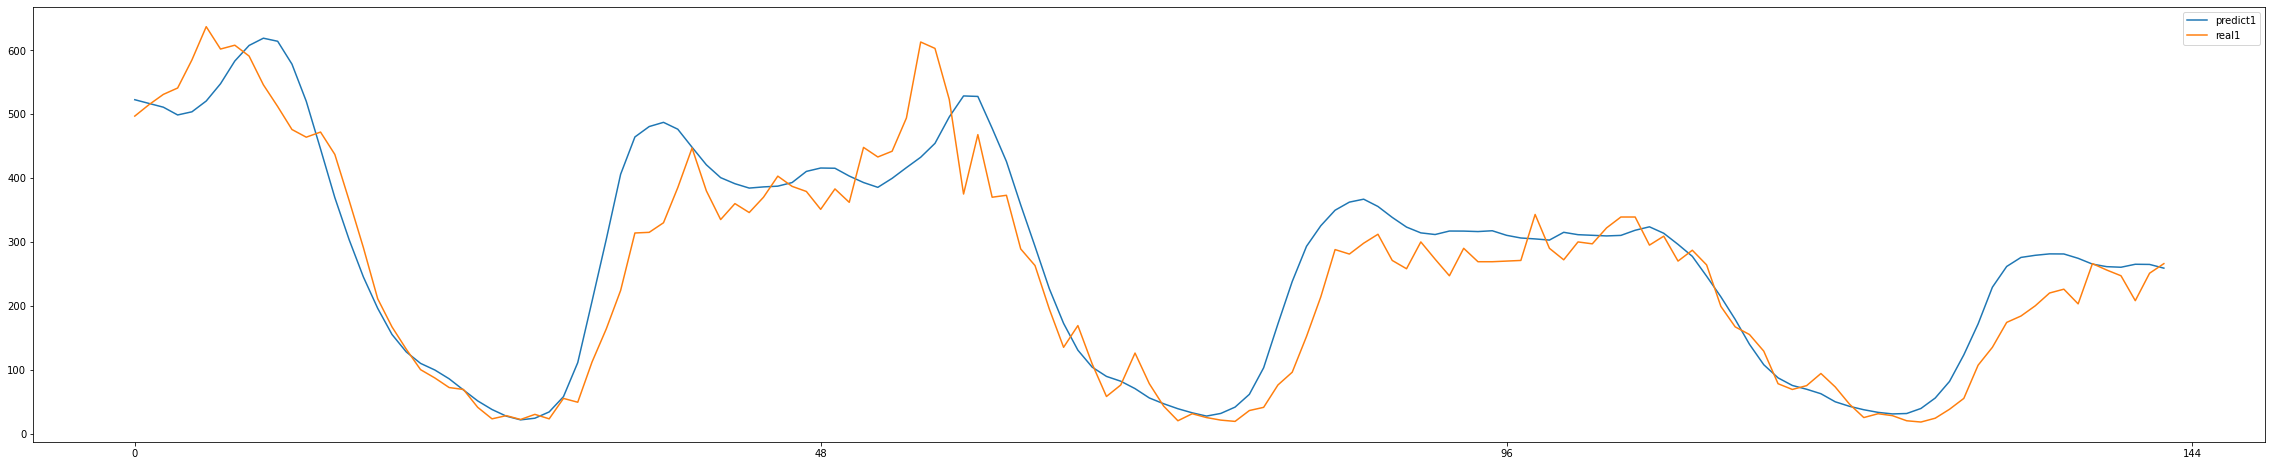

In [17]:
from matplotlib.pyplot import MultipleLocator
line = 1
start = 0
end =-1
predict = np.array(predict)
real = np.array(real)
plt.figure(figsize=(40, 8))
plt.plot(predict[start:end,line+1:line+2])
plt.plot(real[start:end,line:line+1])
plt.legend(['predict' + str(line),'real' + str(line)])
ax=plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(48))
plt.show()